# Variational autoencoder

The variational autoencoder should be able to identify abnormal heartbeat patterns.

In [5]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import gin
from streamer import VAEstreamer
import vae
from loguru import logger
import numpy as np
import sys
import datasets, metrics
import mltrainer
from mltrainer import ReportTypes, Trainer, TrainerSettings


In [6]:
# use the binary data for training the Variational Autoencoder
trainfileVAE = Path('../data/heart_train.parq').resolve()
testfileVAE = Path('../data/heart_test.parq').resolve()
validationfileVAE = Path('../data/heart_test.parq').resolve()

# Remove outliers for training the VAE
traindatasetVAE = datasets.HeartDataset1D(trainfileVAE, target="target", outliersRemoval=True)
testdatasetVAE = datasets.HeartDataset1D(testfileVAE, target="target", outliersRemoval=True)
validationSetVAE = datasets.HeartDataset1D(validationfileVAE, target="target", outliersRemoval=False)

trainstreamerVAE = VAEstreamer(traindatasetVAE, batchsize=32).stream()
teststreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()
validdationstreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()

Training the Autoencoder is really hard, because it could reconstruct a lot of abnormal samples with a reconstruction loss as small as with the normal samples.
Therefore some comparison is made

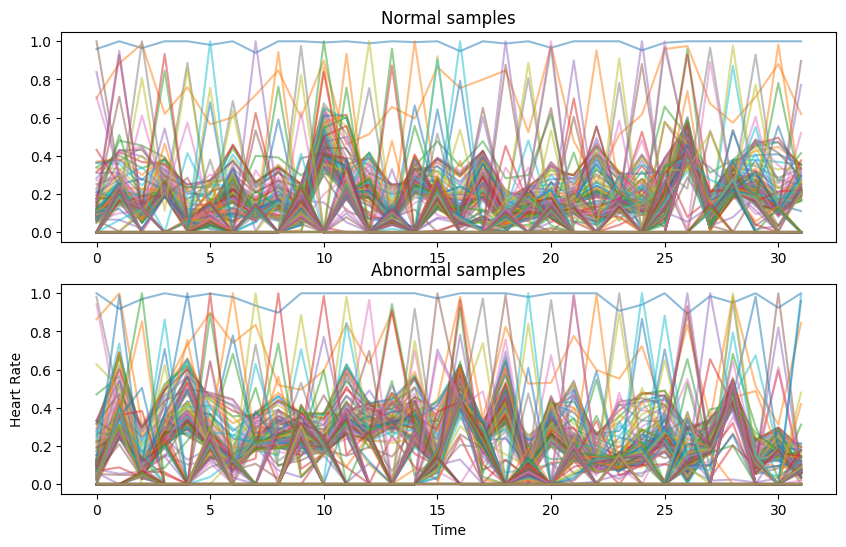

In [7]:
import matplotlib.pyplot as plt

# Initialize a plot
fig = plt.figure(figsize=(10, 6))

XN, X2 = next(trainstreamerVAE)
XA, X2 = next(validdationstreamerVAE)

XN = XN.view(XN.size(0), -1) 
XA = XA.view(XA.size(0), -1) 

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(XN, alpha=0.5)
ax1.set_title('Normal samples')

ax2.plot(XA, alpha=0.5)
ax2.set_title('Abnormal samples')


plt.xlabel('Time')
plt.ylabel('Heart Rate')

# Show plot
plt.show()

In [8]:
gin.parse_config_file(Path('../src/config.gin').resolve())

X1, X2 = next(trainstreamerVAE)

encoder = vae.Encoder()
decoder = vae.Decoder()

latent = encoder(X1)
logger.info(f"the latent shape : {latent.shape}")

x = decoder(latent)
logger.info(f"the shape after: {x.shape}")

lossfn = vae.ReconstructionLoss()
loss = lossfn(x, X2)
logger.info(f"Untrained loss: {loss}")

logger.info(f"starting training for {200} epochs")
autoencoder = vae.AutoEncoder()

settings = TrainerSettings(
    epochs=200,
    metrics=[lossfn],
    logdir="logs",
    train_steps=200,
    valid_steps=200,
    reporttypes=[ReportTypes.TENSORBOARD],
    earlystop_kwargs = {
        "save": False,
        "verbose": True,
        "patience": 8,
    },
    scheduler_kwargs={"factor": 0.1, "patience": 5},
)

trainer = Trainer(
    model=autoencoder,
    settings=settings,
    loss_fn=lossfn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamerVAE,
    validdataloader=teststreamerVAE,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2024-06-21 12:26:13.437 | INFO     | __main__:<module>:9 - the latent shape : torch.Size([32, 1, 24])
2024-06-21 12:26:13.462 | INFO     | __main__:<module>:12 - the shape after: torch.Size([32, 192, 1])
2024-06-21 12:26:13.464 | INFO     | __main__:<module>:16 - Untrained loss: 7738.7373046875
2024-06-21 12:26:13.465 | INFO     | __main__:<module>:18 - starting training for 200 epochs
2024-06-21 12:26:13.470 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/20240621-122613
2024-06-21 12:26:13.472 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:11<00:00, 18.07it/s]
2024-06-21 12:26:28.521 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 170.1260 test 3.6790 metric ['3.6790']
100%|██████████| 200/200 [00:11<00:00, 17.89it/s]
2024-06-21 12:26:44.038 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 2.8708 test 3.0031 metric ['3.0031']
100%|██████████| 200/200 [00:16<00:00, 12.41it/s]
2024-06-21 12:27:09.005 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 2.3258 test 4.1227 metric ['4.1227']
2024-06-21 12:27:09.008 | INFO     | mltrainer.trainer:__call__:234 - best loss: 3.0031, current loss 4.1227.Counter 1/8.
100%|██████████| 200/200 [00:13<00:00, 14.77it/s]
2024-06-21 12:27:27.033 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 2.9117 test 1.7372 metric ['1.7372']
100%|██████████| 200/200 [00:13<00:00, 14.37it/s]
2024-06-21 12:27:46.271 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 2.3014 test 2.8494 metric ['2.8494']
2024-06-21 12:27:46.272 | INFO 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import vae

autoencoder.eval()  # Set the model to evaluation mode
reconstruction_losses = []
targets = []

validation_loader = DataLoader(validationSetVAE, batch_size=1, shuffle=False)

with torch.no_grad():
    for X, y in tqdm(validation_loader, colour="#1e4706"):
        yhat = autoencoder(X)
        X = X.view(X.size(0), -1)  # Flatten the input if necessary

        # Compute reconstruction loss for each item in the batch
        loss = lossfn(X, yhat).cpu().numpy()  # Convert loss to numpy array
        
        # Append each individual loss and target to the lists
        reconstruction_losses.append(loss)
        targets.extend(y.cpu().numpy())
        


100%|██████████| 2911/2911 [00:07<00:00, 392.53it/s]


((383, 2), (1722, 2), (629, 2), (177, 2))

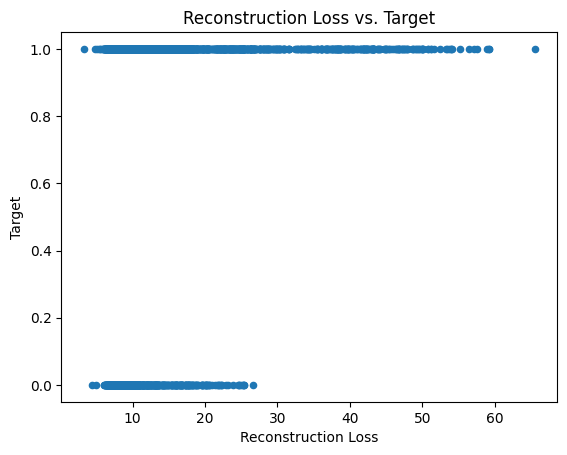

In [10]:
data = {
        'Reconstruction Loss': reconstruction_losses,
        'Target': targets
    }

# Create DataFrame for easy plotting
df = pd.DataFrame(data)
# print(df.head())

# Plot using Seaborn
df.plot.scatter(x='Reconstruction Loss', y='Target')
plt.title('Reconstruction Loss vs. Target')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Target')

threshold = 8
(
    df[(df['Target'] == 1) & (df['Reconstruction Loss'] <= threshold)].shape, #Abnormal <= threshold #bad recall
    df[(df['Target'] == 1) & (df['Reconstruction Loss'] > threshold)].shape, #Abnormal > threshold #good recall
    df[(df['Target'] == 0) & (df['Reconstruction Loss'] > threshold)].shape, #Normal > threshold  # good recall
    df[(df['Target'] == 0) & (df['Reconstruction Loss'] <= threshold)].shape #Normal <= threshold #good recall
) 


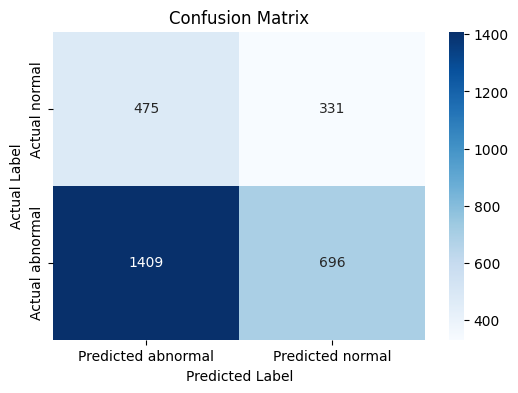

In [11]:
# Calculate confusion matrix
threshold = 9
aw = df[(df['Target'] == 1) & (df['Reconstruction Loss'] <= threshold)].shape[0]  # True positives (Abnormal <= threshold)
ag = df[(df['Target'] == 1) & (df['Reconstruction Loss'] > threshold)].shape[0]   # False negatives (Abnormal > threshold)
nw = df[(df['Target'] == 0) & (df['Reconstruction Loss'] > threshold)].shape[0]   # True negatives (Normal > threshold)
ng = df[(df['Target'] == 0) & (df['Reconstruction Loss'] <= threshold)].shape[0]  # False positives (Normal <= threshold)

# Confusion matrix data
confusion_matrix = [
    [nw, ng],  # Actual Positive (Abnormal)
    [ag, aw]   # Actual Negative (Normal)
]

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted abnormal', 'Predicted normal'],
            yticklabels=['Actual normal', 'Actual abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()
